# This part is to collect data from Internet on the news about Cryptocurrency industry, my main tasks contain two parts:
<h1>1st Part: The trial of web scraping with Mediacloud API</h1><br>
This part is Done currently, and we found little information on the content of the news and attitude from the news.
<br>
<h1>2nd Part: Web Scraping from </h1><br>
We want to find some interesting information from the WebScraper parts. Our hope holds here.

In [23]:
import requests
import csv
import os, sys, getopt, datetime
from pathlib import Path

In [31]:
# read API_KEY file
def read_api_key(filepath):
    """
    Read the Yelp API Key from file.
    
    Args:
        filepath (string): File containing API Key
    Returns:
        api_key (string): The API Key
    """
    
    # feel free to modify this function if you are storing the API Key differently
    with open(filepath, 'r') as f:
        return f.read().replace('\n','')
MY_KEY = read_api_key("mediacloud/mediacloud_key.txt")

In [28]:
def write_json_to_csv(json_list, attribute_name_list, outputfile_name):
    """
        args:
            json_list(JsonList): such as stories, media
            attribute_name_list(list): attribute_name_list == column labels
        returns:
            na
    """
    # check if file exist or not, if exist, then rename old file
    
    filepath = ''
    old_name = outputfile_name
    # check if outf containes the directory info
    pos = outputfile_name.rfind('/')
    if pos != -1:
        filepath = outputfile_name[: pos + 1]
        old_name = outputfile_name[pos + 1: ]
    dt = str(datetime.datetime.now())
    new_outf = Path(outputfile_name)
    if new_outf.is_file():
        # if the file exist, rename it
        newname = old_name[0: len(old_name) - 4]+dt+'.csv'
        os.rename(outputfile_name, filepath + newname)
    # use 'x' to create and write the file
    with open(new_outf, 'w') as csvfile:
        print("open")
        cwriter = csv.DictWriter(csvfile, attribute_name_list, extrasaction='ignore')
        cwriter.writeheader()
        cwriter.writerows(json_list)

In [127]:
def single_extract_from_mediacloud(api_url, params):
    """
        args:
            api_url(str): the open public api: like 'https://api.mediacloud.org/api/v2/stories_public/count/'
            params(dict): the query params and the mediacloud API key
            fieldnames: the attributes/columns/fields for output csv files
        returns:
            outputlist(list): the list of all extraction results
    """
    outputlist = []
    r = requests.get(api_url, params = params, headers = { 'Accept': 'application/json'} )
    data = r.json()
#     print(data)
    if isinstance(data, dict):
        outputlist.extend(data['counts'])
    elif isinstance(data, list):
        outputlist.extend(data)
    return outputlist

In [142]:
def extract_from_mediacloud_by_rows(api_url, params, rows=100, max_extract_rows=500):
    """
        args:
            api_url(str): the open public api: like 'https://api.mediacloud.org/api/v2/stories_public/count/'
            params(dict): the query params and the mediacloud API key
            fieldnames: the attributes/columns/fields for output csv files
            rows(int): rows extraction unit, (media)default=20, not more than 100; (story)default=1000
            max_extract_rows(int): the maximum rows we want to extract
        returns:
            outputlist(list): the list of all extraction results
    """
    outputlist = []
    start = 0
    cnt_rows = 0
    while True:
        print("Fetching {} medias/stories starting from {}".format( rows, start))
        r = requests.get(api_url, params = params, headers = { 'Accept': 'application/json'} )
        data = r.json()
        if len(data) == 0:
            break
        # tell if process media_list or story_list
        if 'stories_public' in api_url:
            start = data[-1]['processed_stories_id']
        else:
            start += rows
        
        cnt_rows += rows
        outputlist.extend(data)
        if cnt_rows >= max_extract_rows: break
    return outputlist

In [110]:
media_url = 'https://api.mediacloud.org/api/v2/media/list'

media_params = { 'start': start, 'rows': rows, 'key': MY_KEY }

media_fieldnames = [
    u'media_id',
    u'url',
    u'name'
]
test_media_list = extract_from_mediacloud_by_rows(media_url, media_params)
write_json_to_csv(media, media_fieldnames, 'tmp/media.csv')

Fetching 100 medias/stories starting from 0
Fetching 100 medias/stories starting from 100
Fetching 100 medias/stories starting from 200
Fetching 100 medias/stories starting from 300
Fetching 100 medias/stories starting from 400
open


# Grab stories by querying stories_public/list

In [143]:
story_url = 'https://api.mediacloud.org/api/v2/stories_public/list/'

story_params = {
        'last_processed_stories_id': start,
        'rows': rows,
        'q': 'text:cryptocurrency',
        'fq': 'publish_date:[2019-01-01T00:00:00Z TO 2019-03-01T00:00:00Z]',
#         'wc': 1, # this wc parameter will severely slow downloading speed
        'key': MY_KEY
    }

# story_list_fieldnames = [
#         u'ap_syndicated',
#         u'collect_date',
#         u'feeds',
#         u'guid',
#         u'language',
#         u'media_id',
#         u'media_name',
#         u'media_url',
#         u'processed_stories_id',
#         u'publish_date',
#         u'stories_id',
#         u'story_tags',
#         u'title',
#         u'url',
#         u'word_count'
#         ]
story_list_fieldnames = list(test_cyrtocurrency_story_list[0].keys())
test_cyrtocurrency_story_list = extract_from_mediacloud_by_rows(story_url, story_params,
                                                                rows=1000, max_extract_rows=2000)
write_json_to_csv(test_cyrtocurrency_story_list, story_list_fieldnames, 'tmp/cryptocurrency_story_list.csv')

Fetching 1000 medias/stories starting from 0
Fetching 1000 medias/stories starting from 1466269874
open


# api/v2/stories_public/count
Be aware that ':' is usually replaced with '%3A' in programmatically generated URLs.
<br>for example: https://api.mediacloud.org/api/v2/stories_public/listlast_processed_stories_id=2523432&q=text:obama+AND+media_id:1
<br>
https://api.mediacloud.org/api/v2/stories_public/count?split=1&split_period=week&q=africa%20AND%20media_id%3A1%20AND%20publish_day%3A%5B2014-01-01T00%3A00%3A00Z%20TO%202014-03-01T00%3A00%3A00Z%5D

In [128]:
count_url = 'https://api.mediacloud.org/api/v2/stories_public/count/'
cryptocurrency_count_params = {
    'q': 'text:cryptocurrency',
    'fq': 'media_id:1',
    'key': MY_KEY
}
r = requests.get(count_url, params = cryptocurrency_count_params, headers = { 'Accept': 'application/json'} )
cryptocurrency_cnt = r.json()
cryptocurrency_cnt

{'count': 283}

In [149]:
def gen_daily_crypto_count_csv(url, query_text, timespan, split_period, csvfile):
    """
    """
    daily_crypto_count_params = {
    'q': query_text,
    'fq': timespan,
    'split': 1,
    'split_period': split_period,
    'key': MY_KEY
    }
    crypto_cnt = single_extract_from_mediacloud(url, daily_crypto_count_params)
    crypto_cnt_fieldnames = list(crypto_cnt[0].keys())
    write_json_to_csv(crypto_cnt, crypto_cnt_fieldnames, csvfile)

In [150]:
# To get daily bitcoin occurrence counts in the world news/medias
count_url = 'https://api.mediacloud.org/api/v2/stories_public/count/'
query_text = 'text:bitcoin'
timespan = 'publish_date:[2013-01-01T00:00:00Z TO 2019-03-07T00:00:00Z]'
daily_split_period = 'day'
gen_daily_crypto_count_csv(count_url, query_text, timespan, daily_split_period, 'tmp/daily_bitcoin_count.csv')

open


In [129]:
daily_crypto_count_params = {
    'q': 'text:cryptocurrency',
    'fq': 'publish_date:[2019-01-01T00:00:00Z TO 2019-03-01T00:00:00Z]',
    'split': 1,
    'split_period': 'day',
    'key': MY_KEY
}
daily_cryptocurrency_cnt = single_extract_from_mediacloud(count_url, daily_crypto_count_params)

weekly_crypto_count_params = {
    'q': 'text:cryptocurrency',
    'fq': 'publish_date:[2019-01-01T00:00:00Z TO 2019-03-01T00:00:00Z]',
    'split': 1,
    'split_period': 'week',
    'key': MY_KEY
}
weekly_cryptocurrency_cnt = single_extract_from_mediacloud(count_url, weekly_crypto_count_params)

cryptocurrency_cnt_fieldnames = [
    u'count',
    u'date'
]
write_json_to_csv(daily_cryptocurrency_cnt, cryptocurrency_cnt_fieldnames, 'tmp/daily_cryptocurrency_count.csv')
write_json_to_csv(weekly_cryptocurrency_cnt, cryptocurrency_cnt_fieldnames, 'tmp/weekly_cryptocurrency_count.csv')

open
open


# api/v2/stories_public/tag_count
The call returns list of the tags most commonly associated with stories that match the given query. The limit parameter s applied before the tag_sets_id parameter, so fewer than limit (or zero) results may be returned for a given tag set even if tags from that tag set are associated with stories matching the query.

e.g Count tags in stories containing the word 'obama' in The New York Times.<br>
https://api.mediacloud.org/api/v2/stories_public/tag_count?q=obama&fq=media_id:1&limit=3

In [135]:
tag_count_url = 'https://api.mediacloud.org/api/v2/stories_public/tag_count/'
tag_count_limit = 300
cryptocurrency_tag_count_params = {
    'q': 'text:cryptocurrency',
#     'fq': 'media_id:1',
    'fq': 'publish_date:[2019-01-01T00:00:00Z TO 2019-03-01T00:00:00Z]',
    'limit': tag_count_limit,
    'key': MY_KEY
}
cryptocurrency_tag_count = single_extract_from_mediacloud(tag_count_url, cryptocurrency_tag_count_params)
list(cryptocurrency_tag_count[0].keys())
write_json_to_csv(cryptocurrency_tag_count, list(cryptocurrency_tag_count[0].keys()),
                  'tmp/cryptocurrency_tag_count.csv')

open


# tag and tag sets
Media Cloud associates tags with media sources, stories, and individual sentences. A tag consists of a short snippet of text, a tags_id, and tag_sets_id. Each tag belongs to a single tag set. The tag set provides a separate name space for a group of related tags. Each tag has a unique name ('tag') within its tag set. Each tag set consists of a tag_sets_id and a uniaue nam

<br> 1. api/v2/tags/list/ <br>
https://api.mediacloud.org/api/v2/tags/list?rows=2&tag_sets_id=5&last_tags_id=8875026 <br>
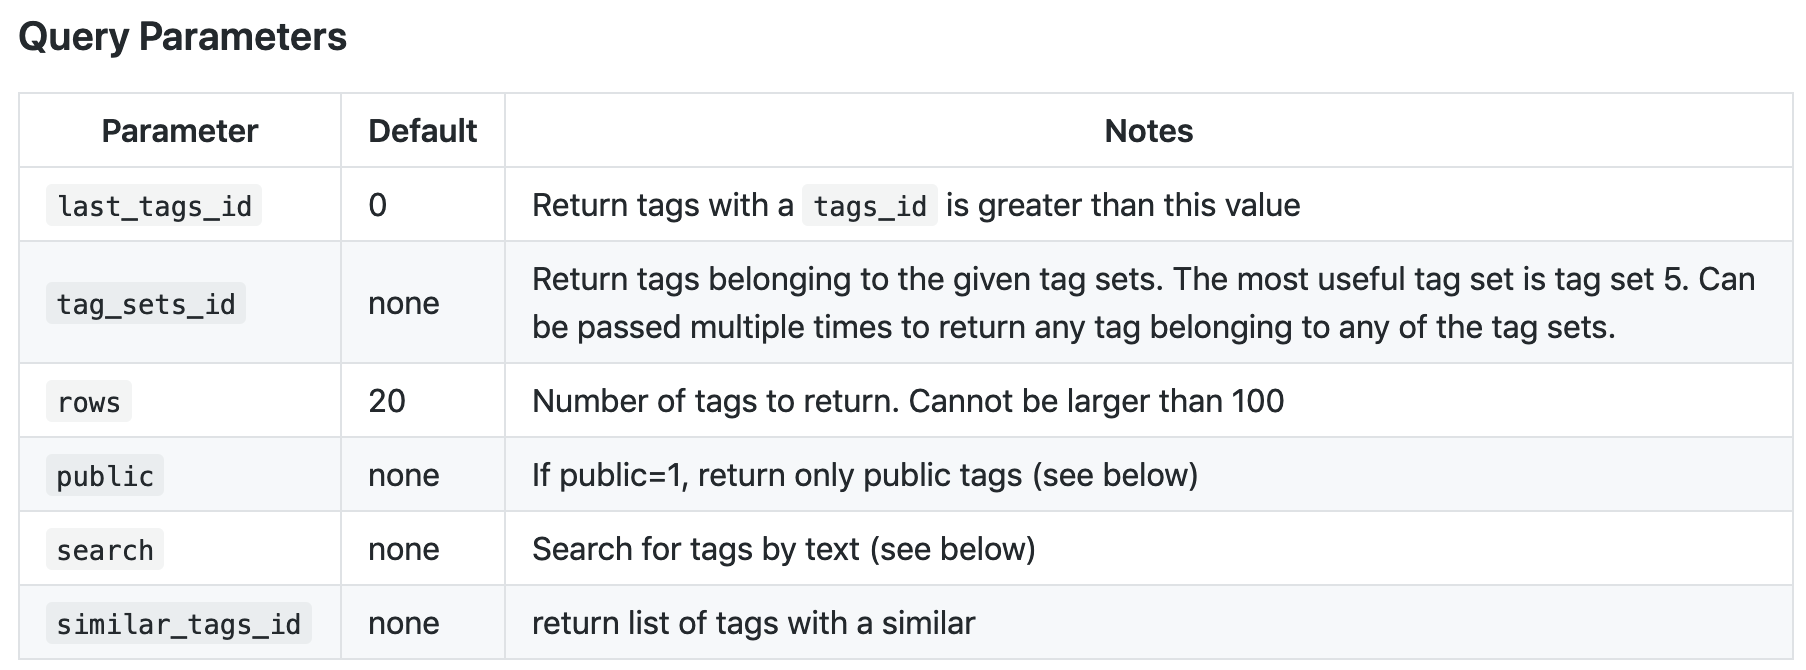
<br> 2. api/v2/tag_sets/list/ <br>
https://api.mediacloud.org/api/v2/tag_sets/list

In [141]:
tags_url = 'https://api.mediacloud.org/api/v2/tags/list'

tags_params = {
    'last_tags_id': 8875026,
    'rows': rows,
#     'tag_set_id': 5,
    'key': MY_KEY }

test_tags = extract_from_mediacloud_by_rows(tags_url, tags_params, rows=100, max_extract_rows=1000)
test_tags
write_json_to_csv(test_tags, list(test_tags[0].keys()), 'tmp/test_tags.csv')

Fetching 100 medias/stories starting from 0
Fetching 100 medias/stories starting from 100
Fetching 100 medias/stories starting from 200
Fetching 100 medias/stories starting from 300
Fetching 100 medias/stories starting from 400
Fetching 100 medias/stories starting from 500
Fetching 100 medias/stories starting from 600
Fetching 100 medias/stories starting from 700
Fetching 100 medias/stories starting from 800
Fetching 100 medias/stories starting from 900
open


In [147]:
tagsets_url = 'https://api.mediacloud.org/api/v2/tag_sets/list'

tagsets_params = {
#     'last_tag_sets_id': start,
    'rows': rows,
    'key': MY_KEY }

test_tagsets = extract_from_mediacloud_by_rows(tagsets_url, tagsets_params, rows=100, max_extract_rows=1000)
# test_tagsets
write_json_to_csv(test_tagsets, list(test_tagsets[0].keys()), 'tmp/test_tagsets.csv')

Fetching 100 medias/stories starting from 0
Fetching 100 medias/stories starting from 100
Fetching 100 medias/stories starting from 200
Fetching 100 medias/stories starting from 300
Fetching 100 medias/stories starting from 400
Fetching 100 medias/stories starting from 500
Fetching 100 medias/stories starting from 600
Fetching 100 medias/stories starting from 700
Fetching 100 medias/stories starting from 800
Fetching 100 medias/stories starting from 900
open


# 2nd Part: Web Scraping from 

We are going to update and modify the previous web scraper from Yelp instance. And modify it to find what we are interested into other websites on Cryptocurrency industry.

Look up online documentation for the Python packages you will use:

* Standard Library: 
    * [io](https://docs.python.org/2/library/io.html)
    * [time](https://docs.python.org/2/library/time.html)
    * [json](https://docs.python.org/2/library/json.html)

* Third Party
    * [requests](http://docs.python-requests.org/en/master/)
    * [Beautiful Soup (version 4)](https://www.crummy.com/software/BeautifulSoup/bs4/doc/)

In [223]:
from bs4 import BeautifulSoup
import re

In [253]:
#   Part of the HTML looks like below:
#     <div class="mh-col-1-2 mh-post-nav-item mh-post-nav-next">
#         <a href="https://cryptocurrencynews.com/daily-news/bitcoin-news/potential-reason-behind-bitcoins-surge/">
#     </div>
def parse_page(html, url):
    """
    Parse the title on for all news in cryptocurrencynews.com.
    
    Args:
        html (string): String of HTML corresponding to a Yelp restaurant

    Returns:
        tuple(list, string): a tuple of two elements
            first element: list of dictionaries corresponding to the extracted review information
            second element: URL for the next page of reviews (or None if it is the last page)
    """
    soup = BeautifulSoup(html,'html.parser')
    title = soup.title.string
#     print('soup.title.string is {}.\n'.format(title))
    date_span_tag = soup.find('span', class_ = 'entry-meta-date updated')
#     print('date is {}.'.format(date_span_tag))
    date = date_span_tag.contents[1].string
    
    author_span_tag = soup.find('span', class_ = 'entry-meta-author author vcard')
    author = author_span_tag.contents[1].string
#     print('author is {}.\n'.format(author))
    
    numberOfViews_span_tag = soup.find('span', style = 'text-transform:capitalize;')
    number_of_views = re.findall(r'\d+', numberOfViews_span_tag.contents[1])[0]
#     print('number_of_reviews is {}.\n'.format(number_of_views))
    
    url_div_tag = soup.find('div', class_ = 'mh-col-1-2 mh-post-nav-item mh-post-nav-next')
#     print(type(url_div_tag))    # 'bs4.element.Tag'
#   use bs tag's contents to get its children: strings and child tags.
    url_next = url_div_tag.contents[1]['href']
    print('url_next is {}'.format(url_next))
    article_list = []
    article_dict = {}
    article_dict['title'] = title
    article_dict['date'] = date
    article_dict['author'] = author
    article_dict['number_of_views'] = int(number_of_views)
    article_dict['url'] = url
#     article_dict['text'] = text
    article_list.append(article_dict)
    return article_list, url_next

In [249]:
def extract_title(url):
    """

    Parameters:
        url (string): Yelp URL corresponding to the restaurant of interest.

    Returns:
        titles (list): list of dictionaries containing extracted review information
    """
    viewed_url.append(url)
    # 1st retrieve the HTML string with specified url
    resp = requests.get(url)
    # 2nd extract the reviews list and url_next
    article_briefs, url_next = parse_page(resp.text, url)
    # if next link is already explored, stop scraping
    if url_next not in viewed_url:
        article_briefs += extract_title(url_next)
    return article_briefs

Retrieve ALL of the news starting from below news Jun 6, 2017 in cryptocurrencynews.com
   * [starting_url](https://cryptocurrencynews.com/daily-news/bitcoin-news/potential-reason-behind-bitcoins-surge/)
<br>As all the news from that website could have next and previous href link. The earliest one link 's previous in the most latest news link.
<br>Thus we use a set to store all the links we have scraped to avoid repeatedly scraping

In [245]:
def extract_article(starting_url):
    viewed_url = []
    article_briefs = extract_title(starting_url)
    print(len(article_briefs))
    return article_briefs

date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2017/06/">Jun 6, 2017</a></span>.
url_next is https://cryptocurrencynews.com/daily-news/bitcoin-news/bitcoin-just-a-bubble-credit-suisse-ceos-prediction/
date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2017/11/">Nov 2, 2017</a></span>.
url_next is https://cryptocurrencynews.com/daily-news/bitcoin-news/breaking-bitcoin-soars-6-7400-just-24-hours/
date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2017/11/">Nov 3, 2017</a></span>.
url_next is https://cryptocurrencynews.com/daily-news/bitcoin-news/can-you-make-a-fortune-out-of-bitcoin-richard-branson-and-bill-gates-seem-to-think-so/
date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2017/11/">Nov 6, 2017</a></span>.
url_next is https:

date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2017/11/">Nov 21, 2017</a></span>.
url_next is https://cryptocurrencynews.com/daily-news/bitcoin-news/breaking-first-bitcoin-mutual-fund-launches-europe/
date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2017/11/">Nov 22, 2017</a></span>.
url_next is https://cryptocurrencynews.com/daily-news/bitcoin-news/keiser-predicts-bitcoin-to-reach-100000/
date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2017/11/">Nov 23, 2017</a></span>.
url_next is https://cryptocurrencynews.com/daily-news/bitcoin-news/bitcoin-cash-back-above-1500/
date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2017/11/">Nov 23, 2017</a></span>.
url_next is https://cryptocurrencynews.com/daily-news/bitcoin-news/gpu-manuf

date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2017/12/">Dec 1, 2017</a></span>.
url_next is https://cryptocurrencynews.com/daily-news/bitcoin-news/bitcoin-futures-get-the-green-light/
date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2017/12/">Dec 1, 2017</a></span>.
url_next is https://cryptocurrencynews.com/daily-news/bitcoin-news/nobel-laureate-robert-j-shiller-believes-bitcoin-will-crash/
date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2017/12/">Dec 2, 2017</a></span>.
url_next is https://cryptocurrencynews.com/daily-news/bitcoin-news/press-secretary-sanders-confirms-white-house-is-watching-bitcoin/
date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2017/12/">Dec 2, 2017</a></span>.
url_next is https://cryptocurrencynews.

date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2017/12/">Dec 7, 2017</a></span>.
url_next is https://cryptocurrencynews.com/daily-news/crypto-news/wall-street-banks-are-saying-no-to-the-bitcoin-futures-contracts/
date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2017/12/">Dec 7, 2017</a></span>.
url_next is https://cryptocurrencynews.com/daily-news/crypto-news/coinbase-not-growing-fast-enough/
date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2017/12/">Dec 7, 2017</a></span>.
url_next is https://cryptocurrencynews.com/daily-news/bitcoin-news/valve-no-longer-accepts-bitcoin-as-payment/
date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2017/12/">Dec 7, 2017</a></span>.
url_next is https://cryptocurrencynews.com/daily-news/bitcoin

date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2017/12/">Dec 15, 2017</a></span>.
url_next is https://cryptocurrencynews.com/daily-news/bitcoin-news/japanese-company-gmo-internet-wants-pay-employees-bitcoin/
date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2017/12/">Dec 15, 2017</a></span>.
url_next is https://cryptocurrencynews.com/daily-news/crypto-news/egaming-platform-wild-crypto-selects-new-ceo-ahead-of-january-20-launch/
date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2017/12/">Dec 15, 2017</a></span>.
url_next is https://cryptocurrencynews.com/daily-news/crypto-news/bitcoin-cash-comeback-on-the-rise-and-breaks-2000/
date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2017/12/">Dec 18, 2017</a></span>.
url_next is https:

date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2018/01/">Jan 12, 2018</a></span>.
url_next is https://cryptocurrencynews.com/daily-news/mark-cuban-the-nbas-dallas-mavericks-owner-will-accept-bitcoin-btc-and-ether-eth-for-tickets/
date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2018/01/">Jan 16, 2018</a></span>.
url_next is https://cryptocurrencynews.com/daily-news/is-the-cryptocurrency-market-entering-a-mature-stage/
date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2018/01/">Jan 16, 2018</a></span>.
url_next is https://cryptocurrencynews.com/daily-news/bitcoin-fell-below-10000-mark-heres-why/
date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2018/01/">Jan 17, 2018</a></span>.
url_next is https://cryptocurrencynews.com/daily-

date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2018/05/">May 1, 2018</a></span>.
url_next is https://cryptocurrencynews.com/daily-news/exchanges/okex-binance-top-crypto-exchange/
date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2018/05/">May 14, 2018</a></span>.
url_next is https://cryptocurrencynews.com/daily-news/exchanges/upbit-raided-crypto-market-drops/
date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2018/05/">May 15, 2018</a></span>.
url_next is https://cryptocurrencynews.com/daily-news/exchanges/four-new-coinbase-products/
date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2018/05/">May 15, 2018</a></span>.
url_next is https://cryptocurrencynews.com/daily-news/exchanges/etoro-crypto-exchange-mobile-wallet/
date is <spa

date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2018/07/">Jul 13, 2018</a></span>.
url_next is https://cryptocurrencynews.com/coinbase-updating-coins-stellar-cardano/
date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2018/07/">Jul 16, 2018</a></span>.
url_next is https://cryptocurrencynews.com/coinbase-lists-securities-sec-approved/
date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2018/07/">Jul 17, 2018</a></span>.
url_next is https://cryptocurrencynews.com/coinmarketcap-addresses-issues/
date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2018/07/">Jul 20, 2018</a></span>.
url_next is https://cryptocurrencynews.com/binance-moves-to-south-korea
date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="ht

date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2018/11/">Nov 13, 2018</a></span>.
url_next is https://cryptocurrencynews.com/idex-redcab-token-ride-sharing/
date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2018/11/">Nov 16, 2018</a></span>.
url_next is https://cryptocurrencynews.com/bitrue-dominates-xrp-market/
date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2018/12/">Dec 17, 2018</a></span>.
url_next is https://cryptocurrencynews.com/coinbase-adds-crypto-crypto-trading/
date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2018/12/">Dec 18, 2018</a></span>.
url_next is https://cryptocurrencynews.com/coinbase-5-billion-altcoin-expansion/
date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://

date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2018/01/">Jan 15, 2018</a></span>.
url_next is https://cryptocurrencynews.com/daily-news/bitcoin-higher-ripple-ethereum-and-bitcoin-cash-plunge/
date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2018/01/">Jan 15, 2018</a></span>.
url_next is https://cryptocurrencynews.com/daily-news/crypto-news/verge-xvg-up-by-600-in-one-month-could-it-be-the-next-monero/
date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2018/01/">Jan 15, 2018</a></span>.
url_next is https://cryptocurrencynews.com/daily-news/crypto-news/bitcoin-fumbles-after-renewed-south-korean-concerns/
date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2018/01/">Jan 16, 2018</a></span>.
url_next is https://cryptocurrencynews.com/

In [251]:
def extract_article(starting_url):
    viewed_url = []
    article_briefs = extract_title(starting_url)
    print(len(article_briefs))
    return article_briefs

In [ ]:
starting_url = 'https://cryptocurrencynews.com/daily-news/bitcoin-news/potential-reason-behind-bitcoins-surge/'
article_briefs = extract_article(starting_url)
# currently allowed to scraping to url 
# The next would be ==> https://cryptocurrencynews.com/daily-news/bitcoin-fell-below-10000-mark-heres-why/
write_json_to_csv(article_briefs, article_briefs[0].keys(), 'tmp/cryptocurrencynews_com_bitcoin_news.csv')

In [244]:
def extend_to_csv(dataset, attribute_name_list, outf):
    """
    """
    with open(outf, 'a') as csvfile:
        print("open - append")
        cwriter = csv.DictWriter(csvfile, attribute_name_list, extrasaction='ignore')
        cwriter.writerows(dataset)

In [250]:
starting_url2 = 'https://cryptocurrencynews.com/daily-news/bitcoin-fell-below-10000-mark-heres-why/'
article_briefs2 = extract_article(starting_url2)

date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2018/01/">Jan 17, 2018</a></span>.
url_next is https://cryptocurrencynews.com/daily-news/alibaba-launches-crypto-mining-platform-despite-chinese-government-restrictions/
date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2018/01/">Jan 17, 2018</a></span>.
url_next is https://cryptocurrencynews.com/daily-news/the-dramatic-cryptocurrency-selloff-wiped-off-200b-in-two-days/
date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2018/01/">Jan 17, 2018</a></span>.
url_next is https://cryptocurrencynews.com/daily-news/new-cryptocurrency-day-traders-are-losing-thousands-but-icos-are-thriving/
date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2018/01/">Jan 17, 2018</a></span>.
url_next is https:

date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2018/05/">May 15, 2018</a></span>.
url_next is https://cryptocurrencynews.com/daily-news/exchanges/etoro-crypto-exchange-mobile-wallet/
date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2018/05/">May 16, 2018</a></span>.
url_next is https://cryptocurrencynews.com/daily-news/exchanges/coincheck-expanding-into-us-market/
date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2018/05/">May 18, 2018</a></span>.
url_next is https://cryptocurrencynews.com/exchanges/huobi-pro-crypto-market-index
date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2018/05/">May 23, 2018</a></span>.
url_next is https://cryptocurrencynews.com/exchanges/bithumb-cryptocurrency-exchange
date is <span class="entry-meta

date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2018/07/">Jul 24, 2018</a></span>.
url_next is https://cryptocurrencynews.com/coinbase-crypto-gift-cards/
date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2018/07/">Jul 25, 2018</a></span>.
url_next is https://cryptocurrencynews.com/etf-unlikely-brian-kelly
date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2018/07/">Jul 26, 2018</a></span>.
url_next is https://cryptocurrencynews.com/winklevoss-twins-second-rejection-etf
date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2018/07/">Jul 27, 2018</a></span>.
url_next is https://cryptocurrencynews.com/huobi-lists-verge/
date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/201

date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2018/12/">Dec 20, 2018</a></span>.
url_next is https://cryptocurrencynews.com/dxexchange-nasdaq-powered/
date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2019/01/">Jan 3, 2019</a></span>.
url_next is https://cryptocurrencynews.com/ethereum-dx-exchange-security-issues/
date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2019/01/">Jan 11, 2019</a></span>.
url_next is https://cryptocurrencynews.com/cryptopia-crypto-hack/
date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2019/01/">Jan 15, 2019</a></span>.
url_next is https://cryptocurrencynews.com/binance-freezes-cryptopia-hack-tokens/
date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurr

date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2018/01/">Jan 15, 2018</a></span>.
url_next is https://cryptocurrencynews.com/daily-news/crypto-news/bitcoin-fumbles-after-renewed-south-korean-concerns/
date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2018/01/">Jan 16, 2018</a></span>.
url_next is https://cryptocurrencynews.com/daily-news/crypto-news/bitcoin-ethereum-ripple-cardano-litecoin-entire-cryptocurrency-market-continue-suffer-major-losses/
date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2018/01/">Jan 16, 2018</a></span>.
url_next is https://cryptocurrencynews.com/daily-news/crypto-news/ripple-extends-the-selloff-down-66-from-an-all-time-high/
date is <span class="entry-meta-date updated"><i class="fa fa-clock-o"></i><a href="https://cryptocurrencynews.com/2018/01/">Jan 16, 2018</a>

In [252]:
extend_to_csv(article_briefs, article_briefs[0].keys(), 'tmp/cryptocurrencynews_com_bitcoin_news.csv')

open - append
